In [1]:
import numpy as np

In [2]:
import seaborn as sns

custom_params = {
    "xtick.direction": "in",
    "ytick.direction": "in",
    "lines.markeredgecolor": "k",
    "lines.markeredgewidth": 1.25,
    "figure.dpi": 200,
    "text.usetex": True,
    "font.family": "serif"}
sns.set_theme(context = "notebook", style="ticks", rc=custom_params) 

In [3]:
bead_density = 1.055
water_density = 1.000
bead_size = 1e-7
particle_volume = 4/3 * np.pi * (bead_size)**3
bead_mass = (bead_density - water_density) * particle_volume

print(f"Bead buoyant mass : {bead_mass:.2e} kg")


kB = 1.380649e-23
T = 300
g = 9.81
g = 100*g

Boltzmann_length = kB*T/(bead_mass*g)

print(f"Boltzmann length : {Boltzmann_length:.2e} m")

Debye_length = 60e-9
B = 4

evanescence = 500e-9
H = 5e-6 # ?
L = 25e-6 #?
W = 25e-6 #?
canal_volume_total = H * L * W
print(f"Total canal volume : {canal_volume_total:.2e} m^3")

phi = 1e-4
N_tot_particles = phi * canal_volume_total / particle_volume

print(f"N_tot_particles : {N_tot_particles:.2e}")

slice_volume = evanescence * L * W
N_slice_particles = phi * slice_volume / particle_volume
print(f"N_slice_particles : {N_slice_particles:.2e}")

ratio_particles = N_tot_particles/N_slice_particles

print(
    f"For a canal of dimensions L={L:.2e}, W={W:.2e}, H={H:.2e}, \n and an evanescent slice of height {evanescence:.2e},\n expect {ratio_particles:.2e} times more particles.")

Bead buoyant mass : 2.30e-22 kg
Boltzmann length : 1.83e-02 m
Total canal volume : 3.13e-15 m^3
N_tot_particles : 7.46e+01
N_slice_particles : 7.46e+00
For a canal of dimensions L=2.50e-05, W=2.50e-05, H=5.00e-06, 
 and an evanescent slice of height 5.00e-07,
 expect 1.00e+01 times more particles.


## Calculating the Gibbz Boltzmann distribution

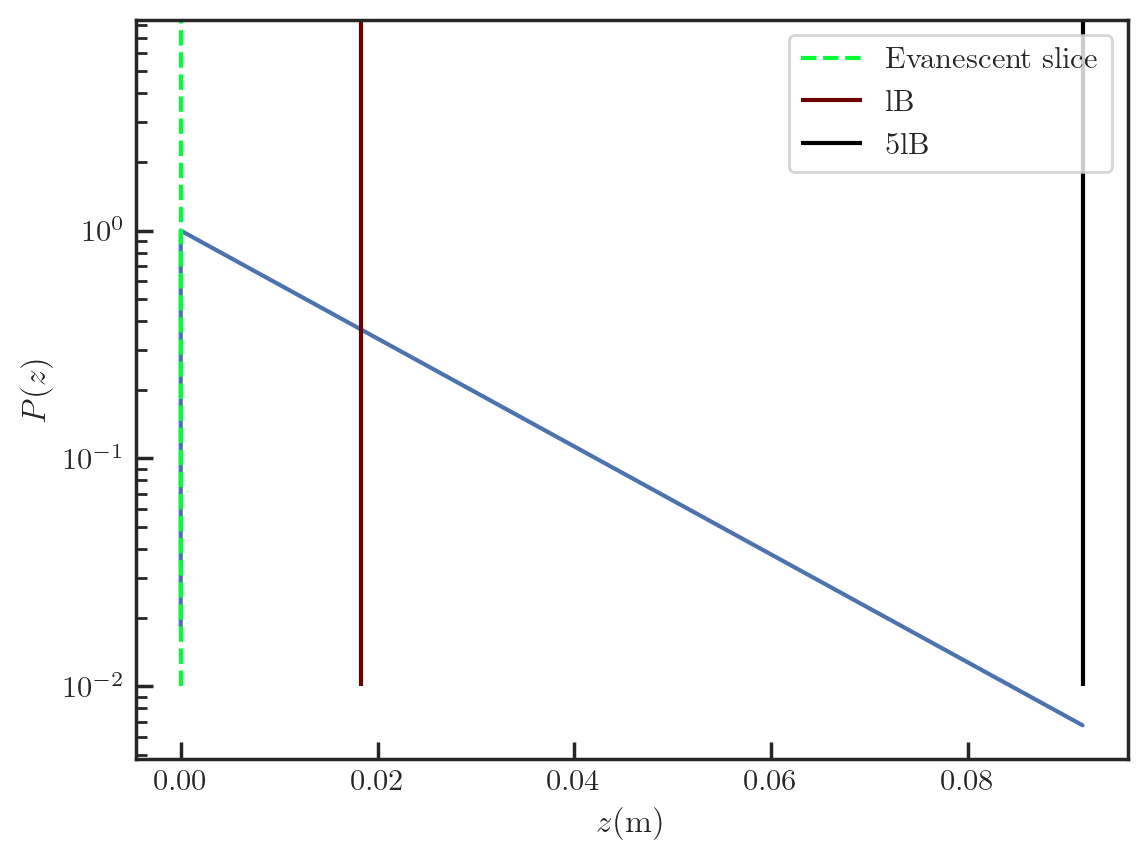

In [4]:
from scipy.integrate import trapezoid
import matplotlib.pyplot as plt

cell_height = np.linspace(0, max(10*H, 5*Boltzmann_length), 100000)


P_eq_nonorm = np.exp(-(B * np.exp(-cell_height/Debye_length) + cell_height/Boltzmann_length))

P_eq_norm = P_eq_nonorm / trapezoid(P_eq_nonorm, cell_height)

plt.semilogy(cell_height, P_eq_nonorm)
plt.vlines(5e-7, 1e-2, 1e6, color = "#00FF37", linestyle = "--", label = "Evanescent slice")
plt.vlines(Boltzmann_length, 1e-2, 1e6, color = "#6D0000", label = "lB")

plt.vlines(5*Boltzmann_length, 1e-2, 1e6, color = '#000000', label = "5lB")

plt.xlabel("$z$(m)")
plt.ylabel("$P(z)$")

plt.legend()

plt.show()

The decay is exponentially small beyond lB. Thus, we can expect the concentration to remain constant provided we chose a lB superior to the evanescence slice height.

REMINDER : launch positions from equilibrium sampling.

I just have to fill with particles until about 5lBs, and wait it out for the system to thermalise. Then, I can lunch the simulations.

## RECAP : How many particles and what size of canal to use

In [7]:
phi_min = 3e-5
phi_max = 3e-4
phi_range = np.array((phi_min, phi_max))

until_five_lB = cell_height <= 4 * Boltzmann_length
N_fivelB = trapezoid(P_eq_norm[until_five_lB], cell_height[until_five_lB])
print(N_fivelB) ## 99% of particles inculded below this, let's say it's phi_0.
# 99% below 5lb.
# 98% below 4lb.
# 94% below 3lb.

until_lB = cell_height <= Boltzmann_length
N_lambda = trapezoid(P_eq_norm[until_lB], cell_height[until_lB])
print(N_lambda) ## 60 % below this

new_initial_phi_range = phi_range * evanescence / (N_lambda * 4 * Boltzmann_length)

print(f"Thus, the initial concentration of particles within a 5lB slab shall be", new_initial_phi_range, ".")




0.9883432966181547
0.6363848465878563
Thus, the initial concentration of particles within a 5lB slab shall be [3.21534225e-10 3.21534225e-09] .


That means I can work with quite dilute solutions while still minimising further dilution.

Next step :

I'll now initiate the simulations by launching positions at random, letting thermalisation do its thing, and then launch the shear.

Step 1 : Initialisaiton.
Define a 5 lB tall box with an open vertical boundary in y and PBC on x and z.
Fill box with random particle positions.
Apply g along y and thermalise.
Recover positions after MSDs are stable and steady (I am expecting a plateau due to weak gravitational confinement).


Step 2 : Simulation.
Apply a shear to the whole system.
Retrieve all y-DISPLACEMENTS.
If a trajectory exits the box OB : end of trajectory.
If a trajectory enters the box, or re-enters a box OB : beginning of a new trajectory.
PBC are treated as such. Anyway, we care only about vertical dispersion.

